In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import urllib2

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
OTP_SERVER_URL = 'http://localhost:5601/otp/'

def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.csv(folderpath, header=True,
                                     inferSchema=True,nullValue="-")
    return data_frame

def read_buste_data_v3(sqlContext, folderpath):
    data_frame = read_hdfs_folder(sqlContext,folderpath)
    
    date = "-".join(folderpath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.date_sub(F.lit(date),1))
    #data_frame = data_frame.withColumn("date", F.unix_timestamp(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

def get_timestamp_in_tz(unixtime_timestamp,ts_format,tz):
    return F.from_utc_timestamp(F.from_unixtime(unixtime_timestamp, ts_format),tz)

In [3]:
spark  = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.crossJoin.enabled', 'true')

sc = spark.sparkContext
sqlContext = pyspark.SQLContext(sc)

In [4]:
base_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v3a/'
#base_folder_path = '/local/tarciso/data/'
od_matrix = read_hdfs_folder(sqlContext,base_folder_path + 'od_matrix/')

In [5]:
od_matrix.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- id: long (nullable = true)
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: timestamp (nullable = true)
 |-- o_

In [6]:
printdf(od_matrix)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration,dist,rn
0,860,2,2240,4494816,-25.440235,-49.277592,840.222,LC011,None,-25.440471,...,6448950,-25.434527,-49.280126,29874,438086664359,32969,78541,759.533333,0.683846,1
1,870,10,2926,5386395,-25.431688,-49.276556,518.881,BC023,None,-25.431630,...,5162628,-25.428355,-49.272707,28429,1262720385319,70255,52607,-1.000000,0.535484,1
2,30,2,1715,6293026,-25.410378,-49.204718,25103.643,BB608,None,-25.410268,...,5846746,-25.410157,-49.204149,32508,206158430263,49275,71111,363.933333,0.062245,1
3,860,8,2241,4494781,-25.436792,-49.274447,12604.144,LC026,None,-25.436816,...,5255201,-25.428123,-49.271896,28556,1666447310868,69745,45888,-1.000000,0.997384,1
4,826,11,2230,6062927,-25.511831,-49.324408,12069.860,JA001,None,-25.511798,...,6416861,-25.510229,-49.326150,35840,1563368095816,76640,36968,-1.000000,0.249584,1
5,777,2,2195,4299860,-25.435179,-49.273374,0.000,JC004,None,-25.435188,...,6222433,-25.428604,-49.270626,26358,798863917103,34748,47558,213.500000,0.781424,1
6,30,3,1715,6292678,-25.489034,-49.226245,11197.387,GR123,None,-25.489063,...,6358078,-25.490593,-49.222306,30062,1022202216489,55367,80712,422.416667,0.431719,1
7,393,5,1907,6350328,-25.434318,-49.274526,11645.587,DN600,None,-25.434348,...,6360100,-25.435370,-49.271665,26180,481036337331,64512,77787,221.250000,0.310218,1
8,778,3,2196,5603972,-25.435144,-49.273284,12300.302,JC007,None,-25.435190,...,6594723,-25.430341,-49.267154,26376,1589137899766,39360,35167,-1.000000,0.815047,1
9,467,14,2818,5136062,-25.444211,-49.267533,1036.662,DN606,None,NaN,...,6405216,-25.444187,-49.267545,26584,627065225481,81022,40917,-1.000000,0.002895,1


In [7]:
printdf(od_matrix.select(['date','route','o_stop_id','o_timestamp','stopPointId','timestamp','o_boarding_id']))

,date,route,o_stop_id,o_timestamp,stopPointId,timestamp,o_boarding_id
0,2017-05-10,860,26163,06:09:29,30633,06:14:13,403726926010
1,2017-05-10,870,26314,16:30:55,28604,16:35:43,635655159957
2,2017-05-10,30,32612,10:41:15,32508,12:10:57,231928234038
3,2017-05-10,860,3280,16:22:25,26163,16:42:40,463856468060
4,2017-05-10,826,33180,18:17:20,30432,18:54:05,549755814128
5,2017-05-10,777,33632,06:39:08,26149,07:00:22,979252543558
6,2017-05-10,30,32600,12:22:47,32577,12:38:45,1219770712102
7,2017-05-10,393,30182,14:55:12,28592,15:05:38,755914244190
8,2017-05-10,778,33533,07:56:00,26146,08:23:16,1606317768917
9,2017-05-10,467,26181,19:30:22,26584,19:34:08,42949673032


In [8]:
od_matrix = od_matrix.withColumn('date_in_ms', F.unix_timestamp(F.col('date'),'yyyy-MM-dd')) \
                        .withColumn('o_time_in_ms', F.unix_timestamp(F.col('o_timestamp'),'HH:mm:ss')) \
                        .withColumn('o_datetime_in_ms', F.col('date_in_ms') + F.col('o_time_in_ms')) \
                        .withColumn('o_datetime',get_timestamp_in_tz(F.col('o_datetime_in_ms'),'yyyy-MM-dd HH:mm:ss','GMT-3'))
                        

In [9]:
printdf(od_matrix.select(['date_in_ms','o_time_in_ms','o_datetime_in_ms','date','o_timestamp','o_datetime']))

,date_in_ms,o_time_in_ms,o_datetime_in_ms,date,o_timestamp,o_datetime
0,1494385200,32969,1494418169,2017-05-10,06:09:29,2017-05-10 06:09:29
1,1494385200,70255,1494455455,2017-05-10,16:30:55,2017-05-10 16:30:55
2,1494385200,49275,1494434475,2017-05-10,10:41:15,2017-05-10 10:41:15
3,1494385200,69745,1494454945,2017-05-10,16:22:25,2017-05-10 16:22:25
4,1494385200,76640,1494461840,2017-05-10,18:17:20,2017-05-10 18:17:20
5,1494385200,34748,1494419948,2017-05-10,06:39:08,2017-05-10 06:39:08
6,1494385200,55367,1494440567,2017-05-10,12:22:47,2017-05-10 12:22:47
7,1494385200,64512,1494449712,2017-05-10,14:55:12,2017-05-10 14:55:12
8,1494385200,39360,1494424560,2017-05-10,07:56:00,2017-05-10 07:56:00
9,1494385200,81022,1494466222,2017-05-10,19:30:22,2017-05-10 19:30:22


In [10]:
od_matrix = od_matrix.withColumn('o_base_timestamp_in_ms', F.col('o_datetime_in_ms') - 60 * 2) \
                        .withColumn('o_base_timestamp',get_timestamp_in_tz(F.col('o_base_timestamp_in_ms'),'yyyy-MM-dd HH:mm:ss','GMT-3')) \
                        .withColumn('o_base_time',F.split(F.col('o_base_timestamp'),'\s+')[1]) \
                        .withColumn('o_base_date',F.split(F.col('o_base_timestamp'),'\s+')[0])


In [11]:
printdf(od_matrix.select('o_datetime_in_ms','o_base_timestamp_in_ms','o_datetime','o_base_timestamp','o_base_date','o_base_time'))

,o_datetime_in_ms,o_base_timestamp_in_ms,o_datetime,o_base_timestamp,o_base_date,o_base_time
0,1494418169,1494418049,2017-05-10 06:09:29,2017-05-10 06:07:29,2017-05-10,06:07:29
1,1494455455,1494455335,2017-05-10 16:30:55,2017-05-10 16:28:55,2017-05-10,16:28:55
2,1494434475,1494434355,2017-05-10 10:41:15,2017-05-10 10:39:15,2017-05-10,10:39:15
3,1494454945,1494454825,2017-05-10 16:22:25,2017-05-10 16:20:25,2017-05-10,16:20:25
4,1494461840,1494461720,2017-05-10 18:17:20,2017-05-10 18:15:20,2017-05-10,18:15:20
5,1494419948,1494419828,2017-05-10 06:39:08,2017-05-10 06:37:08,2017-05-10,06:37:08
6,1494440567,1494440447,2017-05-10 12:22:47,2017-05-10 12:20:47,2017-05-10,12:20:47
7,1494449712,1494449592,2017-05-10 14:55:12,2017-05-10 14:53:12,2017-05-10,14:53:12
8,1494424560,1494424440,2017-05-10 07:56:00,2017-05-10 07:54:00,2017-05-10,07:54:00
9,1494466222,1494466102,2017-05-10 19:30:22,2017-05-10 19:28:22,2017-05-10,19:28:22


In [12]:
def get_otp_itineraries(o_lat,o_lon,d_lat,d_lon,date,time):
    otp_http_request = 'routers/ctba/plan?fromPlace={},{}&toPlace={},{}&mode=TRANSIT,WALK&date={}&time={}'
    otp_request_url = OTP_SERVER_URL + otp_http_request.format(o_lat,o_lon,d_lat,d_lon,date,time)
    #print otp_request_url
    return json.loads(urllib2.urlopen(otp_request_url).read())

In [13]:
test_itinerary = get_otp_itineraries(-25.413083,-49.229020,-25.428322,-49.266739,'05-10-2017','7:19:00')

print test_itinerary

{u'elevationMetadata': {u'geoidElevation': False, u'ellipsoidToGeoidDifference': 3.686111287840708}, u'debugOutput': {u'totalTime': 14277, u'pathCalculationTime': 14236, u'renderingTime': 41, u'timedOut': True, u'precalculationTime': 0, u'pathTimes': []}, u'requestParameters': {u'date': u'05-10-2017', u'fromPlace': u'-25.413083,-49.22902', u'time': u'7:19:00', u'mode': u'TRANSIT,WALK', u'toPlace': u'-25.428322,-49.266739'}, u'error': {u'msg': u'No trip found. There may be no transit service within the maximum specified distance or at the specified time, or your start or end point might not be safely accessible.', u'message': u'PATH_NOT_FOUND', u'id': 404, u'noPath': True}}


### New Approach

In [14]:
trips_otp_response = {}
counter = 0
for row in od_matrix.collect():
        id=long(row['o_boarding_id'])
        trip_plan = get_otp_itineraries(row['o_shape_lat'], row['o_shape_lon'], row['shapeLat'], row['shapeLon'],row['o_base_date'],row['o_base_time'])
        trips_otp_response[id] = trip_plan
        counter+=1

In [15]:
#max_ctr = 1
trips_plans = []

for trip in trips_otp_response.keys():
    #if max_ctr == 0:
    #    break
    if 'plan' in trips_otp_response[trip]:
        itinerary_id = 1
        for itinerary in trips_otp_response[trip]['plan']['itineraries']:
            date = trips_otp_response[trip]['plan']['date']/1000
            leg_id = 1
            for leg in itinerary['legs']:
                route = leg['route'] if leg['route'] != '' else None
                fromStopId = leg['from']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                toStopId = leg['to']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                start_time = long(leg['startTime'])/1000
                end_time = long(leg['endTime'])/1000
                duration = (end_time - start_time)/60
                #date_str = start_time.strftime('%Y-%m-%d')
                #start_time_str = start_time.strftime('%H:%M:%S')
                #end_time_str = end_time.strftime('%H:%M:%S')
                trips_plans.append((date,trip,itinerary_id,leg_id,start_time,end_time,leg['mode'],route,fromStopId,toStopId, duration))
                leg_id += 1
            itinerary_id += 1
    #max_ctr -= 1

labels=['date','user_trip_id','itinerary_id','leg_id','otp_start_time','otp_end_time','mode','route','from_stop_id','to_stop_id','otp_duration_mins']
trips_plans_df = sqlContext.createDataFrame(trips_plans, labels) \
                    .withColumn('date',F.from_unixtime(F.col('date'),'yyyy-MM-dd')) \
                    .withColumn('otp_start_time',F.from_unixtime(F.col('otp_start_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                    .withColumn('otp_end_time',F.from_unixtime(F.col('otp_end_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                    .withColumn('otp_duration_mins',(F.unix_timestamp(F.col('otp_end_time')) - F.unix_timestamp(F.col('otp_start_time')))/60) \
                    .withColumn('route', F.col('route').astype('integer')) \
                    .withColumn('from_stop_id', F.col('from_stop_id').astype('integer')) \
                    .withColumn('to_stop_id', F.col('to_stop_id').astype('integer')) \
                    .orderBy(['date','user_trip_id','itinerary_id','otp_start_time'])

In [16]:
trips_plans_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- mode: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_duration_mins: double (nullable = true)



In [17]:
total_num_trips = trips_plans_df.count()
total_num_bus_trips = trips_plans_df.filter('mode == \'BUS\'').count()
print "Total num Trips:", total_num_trips
print "Total num Bus Trips:", total_num_bus_trips, "(", 100*(total_num_bus_trips/float(total_num_trips)), "%)"

Total num Trips: 42603
Total num Bus Trips: 14148 ( 33.2089289487 %)


In [18]:
printdf(trips_plans_df,l=20)

,date,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,route,from_stop_id,to_stop_id,otp_duration_mins
0,2017-05-10,2,1,1,2017-05-10 08:56:13,2017-05-10 08:56:14,WALK,NaN,NaN,NaN,0.016667
1,2017-05-10,2,1,2,2017-05-10 08:56:15,2017-05-10 09:28:03,BUS,50.0,31638.0,31748.0,31.800000
2,2017-05-10,2,1,3,2017-05-10 09:28:04,2017-05-10 09:28:11,WALK,NaN,NaN,NaN,0.116667
3,2017-05-10,2,2,1,2017-05-10 09:14:48,2017-05-10 09:14:49,WALK,NaN,NaN,NaN,0.016667
4,2017-05-10,2,2,2,2017-05-10 09:14:50,2017-05-10 09:48:00,BUS,50.0,31638.0,31748.0,33.166667
5,2017-05-10,2,2,3,2017-05-10 09:48:01,2017-05-10 09:48:08,WALK,NaN,NaN,NaN,0.116667
6,2017-05-10,2,3,1,2017-05-10 09:34:38,2017-05-10 09:34:39,WALK,NaN,NaN,NaN,0.016667
7,2017-05-10,2,3,2,2017-05-10 09:34:40,2017-05-10 10:07:00,BUS,50.0,31638.0,31748.0,32.333333
8,2017-05-10,2,3,3,2017-05-10 10:07:01,2017-05-10 10:07:08,WALK,NaN,NaN,NaN,0.116667
9,2017-05-10,9,1,1,2017-05-10 18:04:09,2017-05-10 18:04:19,WALK,NaN,NaN,NaN,0.166667


In [19]:
# simple_od_matrix = od_matrix.select(['date','route','o_stop_id','stopPointId','o_boarding_id']) \
#                         .withColumnRenamed('o_stop_id','from_stop_id') \
#                         .withColumnRenamed('stopPointId','to_stop_id')

In [20]:
# simple_od_matrix.printSchema()

In [21]:
# printdf(simple_od_matrix)

In [22]:
# labelled_trips_plans = trips_plans_df.join(simple_od_matrix, on=['date','route','from_stop_id','to_stop_id'], how='inner')

In [23]:
# printdf(labelled_trips_plans)

### Read Bus Data

In [24]:
print base_folder_path

/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v3a/


In [25]:
bus_trips_data = read_buste_data_v3(sqlContext,base_folder_path + '/bulma-output/2017_05_11_veiculos.csv/')

In [26]:
bus_trips_data.printSchema()

root
 |-- route: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)



In [27]:
clean_bus_trips_data = bus_trips_data.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                    .withColumn('route',F.col('route').astype('float')) \
                    .withColumn('date',F.col('date').astype('string')) \
                    .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

In [28]:
clean_bus_trips_data.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: float (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [29]:
printdf(clean_bus_trips_data)

,date,route,busCode,tripNum,stopPointId,timestamp
0,2017-05-10,1.0,BN997,13,31454,2017-05-10 11:25:09
1,2017-05-10,1.0,BN997,15,35219,2017-05-10 12:20:11
2,2017-05-10,1.0,BN997,24,29420,2017-05-10 15:48:08
3,2017-05-10,1.0,BN997,27,35216,2017-05-10 16:47:51
4,2017-05-10,1.0,BN997,29,29420,2017-05-10 17:35:33
5,2017-05-10,1.0,BN998,2,29420,2017-05-10 07:41:43
6,2017-05-10,2.0,DN027,3,10899,2017-05-10 08:17:19
7,2017-05-10,2.0,DN027,14,30225,2017-05-10 15:39:21
8,2017-05-10,10.0,BB001,8,33148,2017-05-10 09:49:56
9,2017-05-10,10.0,BB001,14,33172,2017-05-10 16:58:07


### Finding Real User Trip Beginning Time

In [30]:
trips_plans_df_start = trips_plans_df.withColumn('stopPointId', F.col('from_stop_id'))
trip_plans_start = trips_plans_df_start.join(clean_bus_trips_data, ['date','route','stopPointId'], how='inner') \
                        .na.drop(subset=['timestamp']) \
                        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_start_time')))) \
                        .drop('otp_duration')

In [31]:
printdf(trip_plans_start.select(['date','route','from_stop_id','tripNum','otp_start_time','timestamp','timediff']) \
                .orderBy(['date','route','from_stop_id','otp_start_time','timediff']))

,date,route,from_stop_id,tripNum,otp_start_time,timestamp,timediff
0,2017-05-10,1,26166,13,2017-05-10 11:32:01,2017-05-10 11:30:17,104
1,2017-05-10,1,26166,11,2017-05-10 11:32:01,2017-05-10 11:22:34,567
2,2017-05-10,1,26166,12,2017-05-10 11:32:01,2017-05-10 11:46:41,880
3,2017-05-10,1,26166,12,2017-05-10 11:32:01,2017-05-10 11:07:52,1449
4,2017-05-10,1,26166,14,2017-05-10 11:32:01,2017-05-10 11:57:21,1520
5,2017-05-10,1,26166,10,2017-05-10 11:32:01,2017-05-10 10:57:44,2057
6,2017-05-10,1,26166,13,2017-05-10 11:32:01,2017-05-10 12:10:44,2323
7,2017-05-10,1,26166,15,2017-05-10 11:32:01,2017-05-10 12:18:17,2776
8,2017-05-10,1,26166,11,2017-05-10 11:32:01,2017-05-10 10:45:33,2788
9,2017-05-10,1,26166,14,2017-05-10 11:32:01,2017-05-10 12:30:09,3488


In [32]:
trip_plans_start.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- mode: string (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_duration_mins: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- timediff: long (nullable = true)



In [33]:
printdf(trip_plans_start)

,date,route,stopPointId,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,from_stop_id,to_stop_id,otp_duration_mins,busCode,tripNum,timestamp,timediff
0,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN997,13,2017-05-10 11:25:09,6058
1,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN998,10,2017-05-10 10:51:07,8100
2,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN997,21,2017-05-10 14:28:42,4955
3,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN997,22,2017-05-10 14:50:47,6280
4,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN998,2,2017-05-10 07:29:54,20173
5,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN997,17,2017-05-10 12:52:24,823
6,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN998,7,2017-05-10 09:34:41,12686
7,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN998,13,2017-05-10 12:05:46,3621
8,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN997,1,2017-05-10 06:22:44,24203
9,2017-05-10,1,31454,188978561190,1,2,2017-05-10 13:06:07,2017-05-10 13:18:48,BUS,31454,29082,12.683333,BN997,2,2017-05-10 06:49:45,22582


In [34]:
w = Window.partitionBy(['date','user_trip_id','itinerary_id','route','from_stop_id']).orderBy(['timediff'])

trip_plans_start = trip_plans_start.withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [35]:
printdf(trip_plans_start.select('route','from_stop_id','otp_start_time','timestamp') \
           .orderBy(['route','from_stop_id','otp_start_time']))

,route,from_stop_id,otp_start_time,timestamp
0,1,26166,2017-05-10 11:32:01,2017-05-10 11:30:17
1,1,26166,2017-05-10 11:43:01,2017-05-10 11:46:41
2,1,26166,2017-05-10 19:00:12,2017-05-10 17:33:25
3,1,26360,2017-05-10 08:13:00,2017-05-10 08:35:21
4,1,26375,2017-05-10 10:32:12,2017-05-10 10:27:24
5,1,26375,2017-05-10 15:07:12,2017-05-10 15:02:00
6,1,26375,2017-05-10 15:55:12,2017-05-10 15:50:04
7,1,30749,2017-05-10 06:55:43,2017-05-10 06:52:40
8,1,30749,2017-05-10 11:38:13,2017-05-10 11:42:36
9,1,30749,2017-05-10 15:18:58,2017-05-10 15:19:13


In [36]:
trip_plans_start = trip_plans_start \
        .select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','otp_start_time','timestamp','to_stop_id','otp_end_time']) \
        .withColumnRenamed('timestamp','from_timestamp')
printdf(trip_plans_start)

,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,otp_start_time,from_timestamp,to_stop_id,otp_end_time
0,2017-05-10,8589934685,3,2,169,BC002,16,27290,2017-05-10 17:39:05,2017-05-10 17:56:51,26769,2017-05-10 17:45:41
1,2017-05-10,8589934831,3,2,168,BC004,2,26877,2017-05-10 07:18:45,2017-05-10 07:15:06,28429,2017-05-10 07:48:00
2,2017-05-10,8589934845,1,2,680,HR411,3,31034,2017-05-10 07:26:00,2017-05-10 07:29:53,38528,2017-05-10 07:48:47
3,2017-05-10,17179869217,2,2,860,LC010,1,34113,2017-05-10 06:18:26,2017-05-10 06:17:47,29924,2017-05-10 06:48:56
4,2017-05-10,51539607749,2,2,561,EC002,3,31988,2017-05-10 07:32:59,2017-05-10 07:34:26,26152,2017-05-10 07:44:00
5,2017-05-10,60129542244,1,2,380,LC301,3,33018,2017-05-10 07:10:46,2017-05-10 07:11:08,29914,2017-05-10 07:29:09
6,2017-05-10,68719476860,1,2,40,LB603,5,34140,2017-05-10 17:56:55,2017-05-10 17:57:00,34147,2017-05-10 17:58:33
7,2017-05-10,103079215268,3,2,777,LC027,2,33630,2017-05-10 07:42:43,2017-05-10 07:41:22,26149,2017-05-10 08:13:00
8,2017-05-10,111669149950,2,2,40,BB615,2,34127,2017-05-10 09:37:51,2017-05-10 09:33:38,34169,2017-05-10 09:56:58
9,2017-05-10,146028888332,2,2,160,BC022,5,26635,2017-05-10 11:30:04,2017-05-10 11:31:17,26904,2017-05-10 11:32:01


In [37]:
total_trips_start = trip_plans_start.count()

print "Total Num Trips Start Identified in Data:", total_trips_start, "(", 100*(total_trips_start/float(total_num_bus_trips)), "%)"

trip_plans_start.printSchema()

Total Num Trips Start Identified in Data: 14122 ( 99.8162284422 %)
root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)



### Finding Real User Trip End Time

In [38]:
bus_trips_data2 = read_buste_data_v3(sqlContext,base_folder_path + '/bulma-output/2017_05_11_veiculos.csv/')

In [39]:
clean_bus_trips_data2 = bus_trips_data2.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                    .withColumn('route',F.col('route').astype('integer')) \
                    .withColumn('date',F.col('date').astype('string')) \
                    .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

In [40]:
clean_bus_trips_data2.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [41]:
trip_plans_start.printSchema()

root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)



In [42]:
trip_plans_df_end = trip_plans_start.withColumnRenamed('to_stop_id','stopPointId')
trip_plans_start_end = trip_plans_df_end.join(clean_bus_trips_data2, ['date','route','busCode','tripNum','stopPointId'], how='inner') \
                        .na.drop(subset=['timestamp']) \
                        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_end_time'))))

In [43]:
trip_plans_start_end = trip_plans_start_end.withColumnRenamed('timestamp', 'to_timestamp') \
                .withColumnRenamed('stopPointId','to_stop_id') \
                .orderBy(['date','route','stopPointId','timediff'])
                
printdf(trip_plans_start_end.select(['date','route','to_stop_id','tripNum','to_timestamp','otp_end_time','timediff']))

,date,route,to_stop_id,tripNum,to_timestamp,otp_end_time,timediff
0,2017-05-10,1,26360,22,2017-05-10 14:40:18,2017-05-10 15:10:00,1782
1,2017-05-10,1,26375,14,2017-05-10 12:35:06,2017-05-10 12:36:19,73
2,2017-05-10,1,26375,14,2017-05-10 12:35:06,2017-05-10 12:36:19,73
3,2017-05-10,1,26375,11,2017-05-10 10:53:01,2017-05-10 10:54:26,85
4,2017-05-10,1,26375,16,2017-05-10 13:22:57,2017-05-10 13:20:26,151
5,2017-05-10,1,26375,20,2017-05-10 14:51:17,2017-05-10 14:55:12,235
6,2017-05-10,1,26375,28,2017-05-10 17:20:06,2017-05-10 17:15:19,287
7,2017-05-10,1,26375,22,2017-05-10 15:02:00,2017-05-10 15:07:12,312
8,2017-05-10,1,26375,19,2017-05-10 13:49:55,2017-05-10 13:55:12,317
9,2017-05-10,1,26375,29,2017-05-10 17:36:49,2017-05-10 18:04:06,1637


In [44]:
trip_plans_start_end.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- to_timestamp: string (nullable = true)
 |-- timediff: long (nullable = true)



In [45]:
trips_actual_time = trip_plans_start_end.select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','from_timestamp','to_stop_id','to_timestamp']) \
                        .withColumn('actual_duration_mins', (F.unix_timestamp(F.col('to_timestamp')) - F.unix_timestamp(F.col('from_timestamp')))/60) \
                        .orderBy(['date','user_trip_id','itinerary_id','leg_id'])

In [46]:
total_trips_found = trips_actual_time.count()
print "Total Num Trips Identified in Data:", total_trips_found, "(", 100*(total_trips_found/float(total_num_bus_trips)), "%)"

printdf(trips_actual_time)

Total Num Trips Identified in Data: 13700 ( 96.8334746961 %)


,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,from_timestamp,to_stop_id,to_timestamp,actual_duration_mins
0,2017-05-10,2,1,2,50,DR103,2,31638,2017-05-10 08:57:43,31748,2017-05-10 09:25:21,27.633333
1,2017-05-10,2,2,2,50,LA054,2,31638,2017-05-10 09:13:53,31748,2017-05-10 09:46:32,32.650000
2,2017-05-10,2,3,2,50,JB605,3,31638,2017-05-10 09:31:30,31748,2017-05-10 10:04:05,32.583333
3,2017-05-10,9,1,2,370,LC009,8,30221,2017-05-10 18:15:45,30219,2017-05-10 18:26:50,11.083333
4,2017-05-10,9,3,2,860,LC011,10,30221,2017-05-10 18:24:56,30219,2017-05-10 18:27:05,2.150000
5,2017-05-10,16,1,2,777,JC003,3,33626,2017-05-10 07:11:58,26149,2017-05-10 07:47:04,35.100000
6,2017-05-10,16,2,2,777,JC006,2,33626,2017-05-10 07:23:01,26149,2017-05-10 07:54:36,31.583333
7,2017-05-10,16,3,2,777,LC027,2,33626,2017-05-10 07:40:14,26149,2017-05-10 08:12:45,32.516667
8,2017-05-10,21,2,2,40,LB603,1,35564,2017-05-10 07:02:02,35565,2017-05-10 07:03:11,1.150000
9,2017-05-10,21,3,2,40,MB604,3,35564,2017-05-10 07:07:31,35565,2017-05-10 07:08:40,1.150000


In [47]:
negative_duration_trips = trips_actual_time.filter(trips_actual_time.actual_duration_mins <= 0)

total_trips_negative_duration = negative_duration_trips.count()
print "Total Num Trips With Negative Duration Identified in Data:", total_trips_negative_duration, "(", 100*(total_trips_negative_duration/float(total_num_bus_trips)), "%)"

printdf(negative_duration_trips, l=50)

Total Num Trips With Negative Duration Identified in Data: 573 ( 4.05004240882 %)


,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,from_timestamp,to_stop_id,to_timestamp,actual_duration_mins
0,2017-05-10,32,3,2,614,GR404,3,31638,2017-05-10 18:07:57,31740,2017-05-10 17:56:19,-11.633333
1,2017-05-10,36,2,2,170,BC599,1,806,2017-05-10 07:13:25,27745,2017-05-10 06:48:06,-25.316667
2,2017-05-10,50,2,2,545,KA697,1,30039,2017-05-10 07:36:17,29962,2017-05-10 05:53:41,-102.600000
3,2017-05-10,91,1,2,465,DC983,19,26158,2017-05-10 19:34:13,30716,2017-05-10 18:59:31,-34.700000
4,2017-05-10,91,3,2,467,DN603,15,26181,2017-05-10 20:02:15,30716,2017-05-10 19:09:48,-52.450000
5,2017-05-10,258,3,2,370,LC020,2,26400,2017-05-10 10:12:41,26355,2017-05-10 09:10:53,-61.800000
6,2017-05-10,8589934648,3,2,972,MC300,15,29599,2017-05-10 19:36:32,33681,2017-05-10 18:44:52,-51.666667
7,2017-05-10,8589934785,2,2,266,BN603,16,26364,2017-05-10 17:10:48,35642,2017-05-10 16:23:45,-47.050000
8,2017-05-10,8589934803,1,2,665,EC004,2,7919,2017-05-10 09:06:58,34139,2017-05-10 08:04:55,-62.050000
9,2017-05-10,8589934803,3,2,665,GC016,4,7919,2017-05-10 09:45:49,34139,2017-05-10 08:46:51,-58.966667


In [48]:
trips_actual_time_filtered = trips_actual_time.filter(trips_actual_time.actual_duration_mins > 0)

In [49]:
total_trips_clean = trips_actual_time_filtered.count()
print "Total Num Clean Trips Identified in Data:", total_trips_clean, "(", 100*(total_trips_clean/float(total_num_bus_trips)), "%)"

Total Num Clean Trips Identified in Data: 13127 ( 92.7834322872 %)


### Joining Walk and Bus legs into a single Dataframe

In [50]:
printdf(trips_plans_df,l=20)

,date,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,route,from_stop_id,to_stop_id,otp_duration_mins
0,2017-05-10,2,1,1,2017-05-10 08:56:13,2017-05-10 08:56:14,WALK,NaN,NaN,NaN,0.016667
1,2017-05-10,2,1,2,2017-05-10 08:56:15,2017-05-10 09:28:03,BUS,50.0,31638.0,31748.0,31.800000
2,2017-05-10,2,1,3,2017-05-10 09:28:04,2017-05-10 09:28:11,WALK,NaN,NaN,NaN,0.116667
3,2017-05-10,2,2,1,2017-05-10 09:14:48,2017-05-10 09:14:49,WALK,NaN,NaN,NaN,0.016667
4,2017-05-10,2,2,2,2017-05-10 09:14:50,2017-05-10 09:48:00,BUS,50.0,31638.0,31748.0,33.166667
5,2017-05-10,2,2,3,2017-05-10 09:48:01,2017-05-10 09:48:08,WALK,NaN,NaN,NaN,0.116667
6,2017-05-10,2,3,1,2017-05-10 09:34:38,2017-05-10 09:34:39,WALK,NaN,NaN,NaN,0.016667
7,2017-05-10,2,3,2,2017-05-10 09:34:40,2017-05-10 10:07:00,BUS,50.0,31638.0,31748.0,32.333333
8,2017-05-10,2,3,3,2017-05-10 10:07:01,2017-05-10 10:07:08,WALK,NaN,NaN,NaN,0.116667
9,2017-05-10,9,1,1,2017-05-10 18:04:09,2017-05-10 18:04:19,WALK,NaN,NaN,NaN,0.166667


In [51]:
trips_actual_itineraries = trips_plans_df.join(trips_actual_time_filtered, on=['date','user_trip_id','itinerary_id','leg_id', 'route', 'from_stop_id','to_stop_id'], how='left_outer')

In [52]:
printdf(trips_actual_itineraries.filter('mode == \'BUS\'').orderBy(['itinerary_id','leg_id','otp_start_time']), l=20)

,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins
0,2017-05-10,523986010131,1,1,685,8337,35104,2017-05-10 06:46:41,2017-05-10 07:21:53,BUS,35.200000,HA605,3.0,2017-05-10 06:38:16,2017-05-10 07:17:41,39.416667
1,2017-05-10,1614907703449,1,1,619,30434,36276,2017-05-10 07:01:00,2017-05-10 07:29:43,BUS,28.716667,HA274,2.0,2017-05-10 06:56:29,2017-05-10 07:25:54,29.416667
2,2017-05-10,1546188226637,1,1,650,31050,36275,2017-05-10 07:04:00,2017-05-10 07:28:36,BUS,24.600000,None,NaN,None,None,NaN
3,2017-05-10,824633720868,1,1,876,10320,33773,2017-05-10 07:05:00,2017-05-10 07:10:39,BUS,5.650000,BC299,4.0,2017-05-10 07:03:28,2017-05-10 23:28:52,985.400000
4,2017-05-10,841813590051,1,1,876,10320,34169,2017-05-10 07:05:00,2017-05-10 07:34:20,BUS,29.333333,BC299,4.0,2017-05-10 07:03:28,2017-05-10 23:45:15,1001.783333
5,2017-05-10,51539607710,1,1,535,4664,29622,2017-05-10 07:06:00,2017-05-10 07:20:59,BUS,14.983333,EA076,6.0,2017-05-10 07:04:36,2017-05-10 07:19:58,15.366667
6,2017-05-10,1133871366333,1,1,658,27620,35922,2017-05-10 07:09:00,2017-05-10 07:18:52,BUS,9.866667,JA026,3.0,2017-05-10 07:06:19,2017-05-10 07:17:40,11.350000
7,2017-05-10,944892805244,1,1,876,10320,34122,2017-05-10 08:25:00,2017-05-10 09:00:44,BUS,35.733333,None,NaN,None,None,NaN
8,2017-05-10,257698037789,1,1,812,28138,30307,2017-05-10 09:57:00,2017-05-10 10:03:26,BUS,6.433333,BA295,4.0,2017-05-10 09:46:02,2017-05-10 09:57:19,11.283333
9,2017-05-10,1494648619195,1,1,658,27620,35872,2017-05-10 10:37:00,2017-05-10 10:48:44,BUS,11.733333,JA027,4.0,2017-05-10 10:35:25,2017-05-10 10:44:07,8.700000


In [53]:
trips_actual_itineraries = trips_actual_itineraries.withColumn('considered_duration_mins', F.when(F.col('mode') == F.lit('BUS'), F.col('actual_duration_mins')).otherwise(F.col('otp_duration_mins')))

In [54]:
total_num_legs = trips_actual_itineraries.count()

print "Total Number of Legs:", total_num_legs

printdf(trips_actual_itineraries, l=20)

Total Number of Legs: 42603


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins
0,2017-05-10,37,1,3,NaN,NaN,NaN,2017-05-10 06:52:24,2017-05-10 06:52:36,WALK,0.200000,None,NaN,None,None,NaN,0.200000
1,2017-05-10,198,2,3,NaN,NaN,NaN,2017-05-10 10:06:03,2017-05-10 10:06:23,WALK,0.333333,None,NaN,None,None,NaN,0.333333
2,2017-05-10,8589934599,2,1,NaN,NaN,NaN,2017-05-10 09:42:31,2017-05-10 09:42:36,WALK,0.083333,None,NaN,None,None,NaN,0.083333
3,2017-05-10,8589934650,2,4,204.0,26252.0,26239.0,2017-05-10 07:03:00,2017-05-10 07:14:13,BUS,11.216667,BL072,1.0,2017-05-10 07:04:26,2017-05-10 07:18:11,13.750000,13.750000
4,2017-05-10,8589934775,2,3,NaN,NaN,NaN,2017-05-10 07:14:01,2017-05-10 07:16:27,WALK,2.433333,None,NaN,None,None,NaN,2.433333
5,2017-05-10,8589934845,1,2,680.0,31034.0,38528.0,2017-05-10 07:26:00,2017-05-10 07:48:47,BUS,22.783333,None,NaN,None,None,NaN,NaN
6,2017-05-10,17179869205,2,2,372.0,29922.0,30193.0,2017-05-10 13:52:59,2017-05-10 14:07:49,BUS,14.833333,BC323,7.0,2017-05-10 13:49:38,2017-05-10 14:05:16,15.633333,15.633333
7,2017-05-10,25769804036,3,1,NaN,NaN,NaN,2017-05-10 06:55:40,2017-05-10 06:55:42,WALK,0.033333,None,NaN,None,None,NaN,0.033333
8,2017-05-10,42949672966,1,1,NaN,NaN,NaN,2017-05-10 09:29:29,2017-05-10 09:29:39,WALK,0.166667,None,NaN,None,None,NaN,0.166667
9,2017-05-10,42949673220,2,2,612.0,32208.0,31800.0,2017-05-10 08:27:17,2017-05-10 08:34:02,BUS,6.750000,HA024,10.0,2017-05-10 08:23:36,2017-05-10 08:29:38,6.033333,6.033333


In [55]:
legs_not_fully_identified = trips_actual_itineraries.filter((trips_actual_itineraries.mode == 'BUS') & (trips_actual_itineraries.busCode.isNull()))

In [56]:
total_trips_not_found = legs_not_fully_identified.count()
print "Total Num Trips Not Identified in Data:", total_trips_not_found, "(", 100*(total_trips_not_found/float(total_num_bus_trips)), "%)"

printdf(legs_not_fully_identified, l=20)

Total Num Trips Not Identified in Data: 1021 ( 7.21656771275 %)


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins
0,2017-05-10,8589934845,1,2,680,31034,38528,2017-05-10 07:26:00,2017-05-10 07:48:47,BUS,22.783333,None,None,None,None,None,None
1,2017-05-10,481036337232,2,2,183,28724,26351,2017-05-10 07:17:06,2017-05-10 07:40:00,BUS,22.900000,None,None,None,None,None,None
2,2017-05-10,1202590843073,2,2,370,26400,28586,2017-05-10 08:05:23,2017-05-10 08:09:16,BUS,3.883333,None,None,None,None,None,None
3,2017-05-10,1546188226694,2,2,701,31618,26631,2017-05-10 19:35:00,2017-05-10 20:11:58,BUS,36.966667,None,None,None,None,None,None
4,2017-05-10,1563368095966,1,2,612,39160,28389,2017-05-10 06:24:45,2017-05-10 06:43:00,BUS,18.250000,None,None,None,None,None,None
5,2017-05-10,695784701994,3,2,1,26360,29887,2017-05-10 08:13:00,2017-05-10 08:14:50,BUS,1.833333,None,None,None,None,None,None
6,2017-05-10,962072674539,2,2,10,33171,31747,2017-05-10 16:50:00,2017-05-10 16:50:38,BUS,0.633333,None,None,None,None,None,None
7,2017-05-10,1614907703543,1,2,703,26140,32110,2017-05-10 16:38:00,2017-05-10 16:51:46,BUS,13.766667,None,None,None,None,None,None
8,2017-05-10,68719476908,1,2,972,29599,33375,2017-05-10 09:01:00,2017-05-10 09:22:01,BUS,21.016667,None,None,None,None,None,None
9,2017-05-10,695784702129,3,2,21,33058,33054,2017-05-10 18:36:25,2017-05-10 18:43:02,BUS,6.616667,None,None,None,None,None,None


In [57]:
itineraries_not_fully_identified = legs_not_fully_identified.select(['date','user_trip_id','itinerary_id']).distinct()

In [58]:
num_itineraries_not_fully_identified = itineraries_not_fully_identified.count()
total_num_itineraries = trips_actual_itineraries.select('itinerary_id').count()

print "Number of Itineraries not fully identified:", num_itineraries_not_fully_identified, "(", 100*(num_itineraries_not_fully_identified/float(total_num_itineraries)), "%)"

printdf(itineraries_not_fully_identified)

Number of Itineraries not fully identified: 999 ( 2.34490528836 %)


,date,user_trip_id,itinerary_id
0,2017-05-10,1245540515960,2
1,2017-05-10,1468878815353,3
2,2017-05-10,1305670058260,2
3,2017-05-10,730144440427,1
4,2017-05-10,558345748513,3
5,2017-05-10,395136991364,2
6,2017-05-10,1563368095833,2
7,2017-05-10,1065151889439,2
8,2017-05-10,730144440328,3
9,2017-05-10,231928234141,3


In [59]:
itineraries_fully_identified = trips_actual_itineraries.select(['date','user_trip_id','itinerary_id']).subtract(itineraries_not_fully_identified)

In [60]:
trips_actual_itineraries_filtered = trips_actual_itineraries.join(itineraries_fully_identified, on=['date','user_trip_id','itinerary_id'], how='inner')

In [61]:
total_num_filtered_legs = trips_actual_itineraries_filtered.count()

print "Total Number of Filtered Legs (whose itineraries were fully identified):", total_num_filtered_legs, "(", 100*(total_num_filtered_legs/float(total_num_legs)), "%)"

printdf(trips_actual_itineraries_filtered)

Total Number of Filtered Legs (whose itineraries were fully identified): 39412 ( 92.509917142 %)


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins
0,2017-05-10,103079215395,1,2,372.0,26336.0,30791.0,2017-05-10 12:12:00,2017-05-10 12:39:43,BUS,27.716667,BC313,5.0,2017-05-10 12:11:22,2017-05-10 12:37:01,25.650000,25.650000
1,2017-05-10,103079215395,1,3,NaN,NaN,NaN,2017-05-10 12:39:44,2017-05-10 12:39:49,WALK,0.083333,None,NaN,None,None,NaN,0.083333
2,2017-05-10,103079215395,1,1,NaN,NaN,NaN,2017-05-10 12:11:53,2017-05-10 12:11:59,WALK,0.100000,None,NaN,None,None,NaN,0.100000
3,2017-05-10,180388626441,3,2,861.0,30220.0,26165.0,2017-05-10 08:48:40,2017-05-10 09:05:00,BUS,16.333333,LC851,4.0,2017-05-10 08:44:19,2017-05-10 09:03:00,18.683333,18.683333
4,2017-05-10,180388626441,3,3,NaN,NaN,NaN,2017-05-10 09:05:01,2017-05-10 09:09:22,WALK,4.350000,None,NaN,None,None,NaN,4.350000
5,2017-05-10,180388626441,3,1,NaN,NaN,NaN,2017-05-10 08:48:37,2017-05-10 08:48:39,WALK,0.033333,None,NaN,None,None,NaN,0.033333
6,2017-05-10,197568495877,2,2,870.0,34315.0,34636.0,2017-05-10 13:15:33,2017-05-10 13:21:20,BUS,5.783333,BC023,7.0,2017-05-10 13:08:57,2017-05-10 13:13:43,4.766667,4.766667
7,2017-05-10,197568495877,2,1,NaN,NaN,NaN,2017-05-10 13:15:25,2017-05-10 13:15:32,WALK,0.116667,None,NaN,None,None,NaN,0.116667
8,2017-05-10,197568495877,2,3,NaN,NaN,NaN,2017-05-10 13:21:21,2017-05-10 13:21:37,WALK,0.266667,None,NaN,None,None,NaN,0.266667
9,2017-05-10,214748364863,3,2,171.0,37171.0,28326.0,2017-05-10 08:23:03,2017-05-10 08:47:00,BUS,23.950000,BC007,4.0,2017-05-10 07:59:40,2017-05-10 08:27:44,28.066667,28.066667


### Aggregating Itineraries Legs to compute metrics on them

In [62]:
trips_itineraries_duration = trips_actual_itineraries_filtered.groupBy(['date', 'user_trip_id', 'itinerary_id']).agg(F.sum('considered_duration_mins').alias('duration')).orderBy(['date','user_trip_id','itinerary_id'])

In [63]:
printdf(trips_itineraries_duration)

,date,user_trip_id,itinerary_id,duration
0,2017-05-10,2,1,27.766667
1,2017-05-10,2,2,32.783333
2,2017-05-10,2,3,32.716667
3,2017-05-10,9,1,11.300000
4,2017-05-10,9,2,3.383333
5,2017-05-10,9,3,2.366667
6,2017-05-10,16,1,36.350000
7,2017-05-10,16,2,32.833333
8,2017-05-10,16,3,33.766667
9,2017-05-10,21,1,5.366667


In [64]:
#Sanity Checks
#printdf(trips_itineraries_duration.filter(trips_itineraries_duration.user_trip_id == 8589934845))

In [65]:
#Sanity Checks
#printdf(trips_actual_itineraries.filter(trips_actual_itineraries.user_trip_id == 8589934845), l=40)

In [66]:
itineraries_window = Window.partitionBy(['date','user_trip_id']).orderBy(['duration'])
itineraries_ranking_duration = trips_itineraries_duration.withColumn('rank', F.row_number().over(itineraries_window))

In [67]:
printdf(itineraries_ranking_duration)

,date,user_trip_id,itinerary_id,duration,rank
0,2017-05-10,317827580172,3,3.033333,1
1,2017-05-10,317827580172,2,3.183333,2
2,2017-05-10,317827580172,1,5.916667,3
3,2017-05-10,377957122336,1,9.050000,1
4,2017-05-10,377957122336,3,9.750000,2
5,2017-05-10,395136991379,3,29.333333,1
6,2017-05-10,446676599020,1,5.616667,1
7,2017-05-10,446676599020,2,8.116667,2
8,2017-05-10,446676599020,3,15.066667,3
9,2017-05-10,481036337172,2,11.750000,1


In [68]:
best_itineraries_duration = itineraries_ranking_duration.filter(itineraries_ranking_duration.rank == 1)

In [69]:
printdf(best_itineraries_duration)

,date,user_trip_id,itinerary_id,duration,rank
0,2017-05-10,317827580172,3,3.033333,1
1,2017-05-10,377957122336,1,9.050000,1
2,2017-05-10,395136991379,3,29.333333,1
3,2017-05-10,446676599020,1,5.616667,1
4,2017-05-10,481036337172,2,11.750000,1
5,2017-05-10,601295421467,3,14.150000,1
6,2017-05-10,609885356162,1,3.550000,1
7,2017-05-10,644245094507,2,5.800000,1
8,2017-05-10,687194767369,3,17.216667,1
9,2017-05-10,712964571307,3,17.450000,1


In [70]:
executed_trips_duration = od_matrix.withColumnRenamed('o_boarding_id','user_trip_id') \
                            .withColumn('date',F.from_unixtime(F.unix_timestamp(F.col('date')), 'yyyy-MM-dd')) \
                            .withColumn('from_timestamp', F.concat(F.col('date'),F.lit(' '),F.col('o_timestamp'))) \
                            .withColumn('to_timestamp', F.concat(F.col('date'),F.lit(' '),F.col('timestamp'))) \
                            .withColumn('executed_duration', (F.unix_timestamp('to_timestamp') - F.unix_timestamp('from_timestamp'))/60) \
                            .select(['date','user_trip_id','executed_duration'])                            

In [71]:
printdf(executed_trips_duration)

,date,user_trip_id,executed_duration
0,2017-05-10,403726926010,4.733333
1,2017-05-10,635655159957,4.800000
2,2017-05-10,231928234038,89.700000
3,2017-05-10,463856468060,20.250000
4,2017-05-10,549755814128,36.750000
5,2017-05-10,979252543558,21.233333
6,2017-05-10,1219770712102,15.966667
7,2017-05-10,755914244190,10.433333
8,2017-05-10,1606317768917,27.266667
9,2017-05-10,42949673032,3.766667


In [72]:
duration_improvement_capacity = best_itineraries_duration.join(executed_trips_duration, on=['date','user_trip_id']) \
                                    .withColumn('imp_capacity', F.col('executed_duration') - F.col('duration'))

In [73]:
printdf(duration_improvement_capacity)

,date,user_trip_id,itinerary_id,duration,rank,executed_duration,imp_capacity
0,2017-05-10,317827580172,3,3.033333,1,41.650000,38.616667
1,2017-05-10,377957122336,1,9.050000,1,30.483333,21.433333
2,2017-05-10,395136991379,3,29.333333,1,28.116667,-1.216667
3,2017-05-10,446676599020,1,5.616667,1,6.050000,0.433333
4,2017-05-10,481036337172,2,11.750000,1,11.933333,0.183333
5,2017-05-10,601295421467,3,14.150000,1,34.733333,20.583333
6,2017-05-10,609885356162,1,3.550000,1,3.800000,0.250000
7,2017-05-10,644245094507,2,5.800000,1,38.966667,33.166667
8,2017-05-10,687194767369,3,17.216667,1,62.383333,45.166667
9,2017-05-10,712964571307,3,17.450000,1,10.433333,-7.016667


In [74]:
printdf(duration_improvement_capacity.select(['duration','executed_duration','imp_capacity']).describe())

,summary,duration,executed_duration,imp_capacity
0,count,4991,4991,4991
1,mean,16.07108461898082,41.08080211046552,25.009717491484675
2,stddev,14.670750642732239,107.3664527259159,106.21984637345726
3,min,0.18333333333333332,0.016666666666666666,-114.23333333333333
4,max,557.7,1088.7166666666667,1064.6000000000001


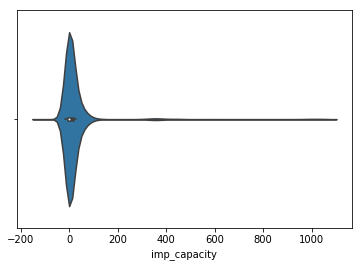

In [75]:
sns.violinplot(x=duration_improvement_capacity.toPandas()["imp_capacity"])

### Appending Real Trips to OTP-Suggested Trips for overall analysis

In [71]:
od_matrix_itineraries = od_matrix \
                            .withColumnRenamed('o_boarding_id','user_trip_id') \
                            .withColumn('itinerary_id',F.lit(0)) \
                            .withColumn('leg_id',F.lit(1)) \
                            .withColumnRenamed('o_stop_id','from_stop_id') \
                            .withColumnRenamed('stopPointId','to_stop_id') \
                            .withColumn('start_time', F.lit(None)) \
                            .withColumn('end_time', F.lit(None)) \
                            .withColumn('mode', F.lit('BUS')) \
                            .withColumn('otp_duration_mins', F.lit(None)) \
                            .withColumn('date', F.from_unixtime(F.unix_timestamp(F.col('date')), 'yyyy-MM-dd')) \
                            .withColumn('from_timestamp', F.concat(F.col('date'),F.lit(' '),F.col('o_timestamp'))) \
                            .withColumn('to_timestamp', F.concat(F.col('date'),F.lit(' '),F.col('timestamp'))) \
                            .withColumn('actual_duration_mins', (F.unix_timestamp('to_timestamp') - F.unix_timestamp('from_timestamp'))/60) \
                            .withColumn('considered_duration_mins', F.col('actual_duration_mins')) \
                            .select(['date','user_trip_id','itinerary_id','leg_id','route','from_stop_id','to_stop_id','start_time','end_time','mode','otp_duration_mins','busCode','tripNum','from_timestamp','to_timestamp','actual_duration_mins','considered_duration_mins'])

In [72]:
printdf(od_matrix_itineraries)

,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,start_time,end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins
0,2017-05-10,403726926010,0,1,860,26163,30633,None,None,BUS,None,LC011,2,2017-05-10 06:09:29,2017-05-10 06:14:13,4.733333,4.733333
1,2017-05-10,635655159957,0,1,870,26314,28604,None,None,BUS,None,BC023,10,2017-05-10 16:30:55,2017-05-10 16:35:43,4.800000,4.800000
2,2017-05-10,231928234038,0,1,30,32612,32508,None,None,BUS,None,BB608,2,2017-05-10 10:41:15,2017-05-10 12:10:57,89.700000,89.700000
3,2017-05-10,463856468060,0,1,860,3280,26163,None,None,BUS,None,LC026,8,2017-05-10 16:22:25,2017-05-10 16:42:40,20.250000,20.250000
4,2017-05-10,549755814128,0,1,826,33180,30432,None,None,BUS,None,JA001,11,2017-05-10 18:17:20,2017-05-10 18:54:05,36.750000,36.750000
5,2017-05-10,979252543558,0,1,777,33632,26149,None,None,BUS,None,JC004,2,2017-05-10 06:39:08,2017-05-10 07:00:22,21.233333,21.233333
6,2017-05-10,1219770712102,0,1,30,32600,32577,None,None,BUS,None,GR123,3,2017-05-10 12:22:47,2017-05-10 12:38:45,15.966667,15.966667
7,2017-05-10,755914244190,0,1,393,30182,28592,None,None,BUS,None,DN600,5,2017-05-10 14:55:12,2017-05-10 15:05:38,10.433333,10.433333
8,2017-05-10,1606317768917,0,1,778,33533,26146,None,None,BUS,None,JC007,3,2017-05-10 07:56:00,2017-05-10 08:23:16,27.266667,27.266667
9,2017-05-10,42949673032,0,1,467,26181,26584,None,None,BUS,None,DN606,14,2017-05-10 19:30:22,2017-05-10 19:34:08,3.766667,3.766667


In [73]:
overall_itineraries_ranking = trips_actual_itineraries.union(od_matrix_itineraries) \
    .orderBy('date','user_trip_id','itinerary_id','leg_id')

### Aggregating Itineraries Legs to compute metrics on them

In [74]:
overall_trips_itineraries_duration = overall_itineraries_ranking.groupBy(['date', 'user_trip_id', 'itinerary_id']).agg(F.sum('considered_duration_mins').alias('duration')).orderBy(['date','user_trip_id','duration'])

In [75]:
printdf(overall_trips_itineraries_duration)

,date,user_trip_id,itinerary_id,duration
0,2017-05-10,2,0,27.433333
1,2017-05-10,2,1,27.766667
2,2017-05-10,2,3,32.716667
3,2017-05-10,2,2,32.783333
4,2017-05-10,9,0,0.900000
5,2017-05-10,9,3,2.366667
6,2017-05-10,9,2,3.383333
7,2017-05-10,9,1,11.300000
8,2017-05-10,16,0,30.216667
9,2017-05-10,16,2,32.833333


In [76]:
itineraries_window = Window.partitionBy(['date','user_trip_id']).orderBy(['duration'])
user_trips_ranks = overall_trips_itineraries_duration.withColumn('rank', F.row_number().over(itineraries_window))

In [77]:
printdf(user_trips_ranks)

,date,user_trip_id,itinerary_id,duration,rank
0,2017-05-10,317827580172,3,3.033333,1
1,2017-05-10,317827580172,2,3.183333,2
2,2017-05-10,317827580172,1,5.916667,3
3,2017-05-10,317827580172,0,41.650000,4
4,2017-05-10,377957122336,2,-36.733333,1
5,2017-05-10,377957122336,1,9.050000,2
6,2017-05-10,377957122336,3,9.750000,3
7,2017-05-10,377957122336,0,30.483333,4
8,2017-05-10,395136991379,1,1.183333,1
9,2017-05-10,395136991379,2,1.183333,2


In [78]:
user_real_trip_rank = user_trips_ranks.filter(user_trips_ranks.itinerary_id == 0)

In [79]:
printdf(user_real_trip_rank.filter(overall_trips_itineraries_duration.user_trip_id == 231928234038))

,date,user_trip_id,itinerary_id,duration,rank
0,2017-05-10,231928234038,0,89.7,1


In [80]:
printdf(od_matrix.filter(od_matrix['o_boarding_id'] == 231928234038) \
       .select(['date','route','o_stop_id','o_timestamp','stopPointId','timestamp','o_boarding_id','cardNum']))

,date,route,o_stop_id,o_timestamp,stopPointId,timestamp,o_boarding_id,cardNum
0,2017-05-10,30,32612,10:41:15,32508,12:10:57,231928234038,1809130


In [81]:
od_matrix.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- id: long (nullable = true)
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: timestamp (nullable = true)
 |-- o_